0
100%|██████████| 500/500 [24:39<00:00,  2.96s/trial, best loss: 0.5312487614333293]
Best Hyperparameters: {'colsample_bytree': 0.8789632642627835, 'gamma': 0.2631301838167067, 'huber_slope': 0.2998909278382967, 'learning_rate': 0.04319768621363935, 'max_delta_step': 9.0, 'max_depth': 10.0, 'min_child_weight': 3.0, 'n_estimators': 660.0, 'reg_alpha': 0.01021238762847951, 'reg_lambda': 1.9486025674605827, 'subsample': 0.7354847996384664}


/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/xgboost/core.py:160: UserWa

Optimal number of features: 7


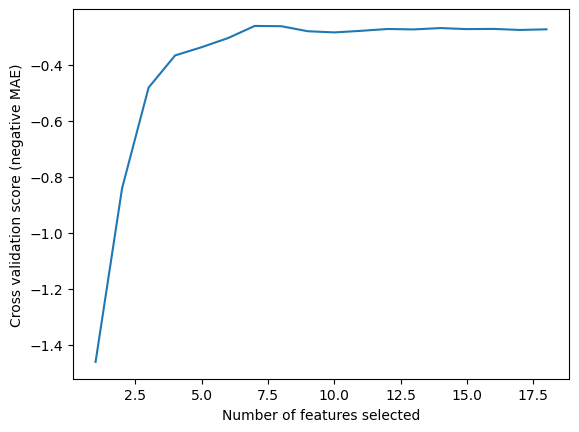

/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:01:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance
Test MSE: 16.287356196859527
Test RMSE: 4.035759680265851
Test MAE: 0.233283759255877
Test R² Score: 0.8470652103424072


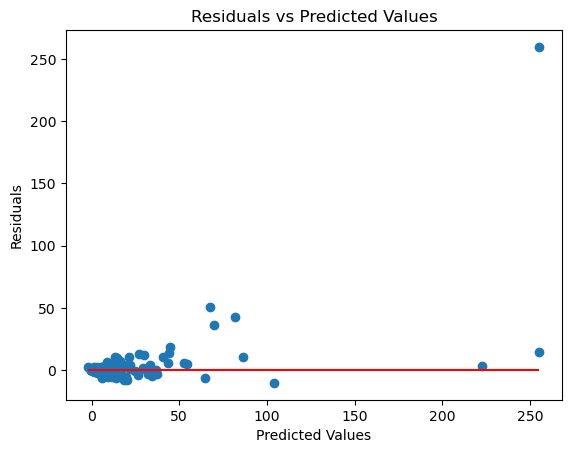

In [3]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np
import matplotlib.pyplot as plt
import json
from joblib import dump

df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data.feather")

# Select the features (X) and target (y) for modeling
# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_this_year', 'sales_last_year', 'sales_revenue',
                                                         'price', 'sales_to_stock_ratio', 'rolling_12_month_sales', 'cogs',
                                                         'margin', 'quantity', 'demand'}]
X = df[feature_cols]
y = df['rolling_12_month_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(y_train.min())

# Define preprocessing pipeline
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power_trans', PowerTransformer(method='yeo-johnson'))]),
        numerical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define space for Hyperopt
space = {
    'objective': 'reg:pseudohubererror',
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
    'gamma': hp.uniform('gamma', 0.25, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 3, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 350, 750, 10),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_delta_step': hp.quniform('max_delta_step', 5, 10, 1),
    'huber_slope': hp.uniform('huber_slope', 0.2, 0.3),
}

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the scoring function for cross-validation
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step']) 
    
    model = XGBRegressor(**params)
    # Store the scores for each fold
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='neg_mean_absolute_error', cv=5)
    return {'loss': -scores.mean(), 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print("Best Hyperparameters:", best_hyperparams)

# Correctly casting the best hyperparameters to their correct types
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['max_delta_step'] = int(best_hyperparams['max_delta_step'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

# Train the model with the best hyperparameters
model = XGBRegressor(**best_hyperparams)

rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring='neg_mean_absolute_error')

# Fit RFE
rfecv.fit(X_train_transformed, y_train)

selected_features_mask = rfecv.support_

# Get the ranking of the features
feature_ranking = rfecv.ranking_

# Get the selected features from your preprocessor
selected_features = [feature for feature, selected in zip(numerical_features, selected_features_mask) if selected]

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Save the selected features and the best hyperparameters to a JSON file
results_dict = {
    "selected_features": selected_features,
    "best_hyperparameters": best_hyperparams
}

with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'w') as fp:
    json.dump(results_dict, fp, indent=4)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (negative MAE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

#transform the model to use the best features
X_train_transformed_rfe = rfecv.transform(X_train_transformed)
X_test_transformed_rfe = rfecv.transform(X_test_transformed)

model.fit(X_train_transformed_rfe, y_train)

#save the preprocessor and the model for application
dump(preprocessor, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/preprocessor.joblib')
dump(model, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/xgb_regressor_with_selected_features.joblib')
y_pred = model.predict(X_test_transformed_rfe)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nModel Performance')
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")

# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


In [4]:
# Load the hyperparameters from the JSON file
with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'r') as file:
    hyperparameters = json.load(file)

# Print the hyperparameters
print("Hyperparameters saved in the JSON file:")
print(hyperparameters)

Hyperparameters saved in the JSON file:
{'selected_features': ['months_no_sale', 'special_orders_ytd', 'rolling_3_month_sales', 'cost_per_unit', 'margin_percentage', 'gross_profit', 'seasonal_component'], 'best_hyperparameters': {'colsample_bytree': 0.8789632642627835, 'gamma': 0.2631301838167067, 'huber_slope': 0.2998909278382967, 'learning_rate': 0.04319768621363935, 'max_delta_step': 9, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 660, 'reg_alpha': 0.01021238762847951, 'reg_lambda': 1.9486025674605827, 'subsample': 0.7354847996384664}}


In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Load the data
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data.feather")

# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_this_year', 'sales_last_year', 'sales_revenue', 'quantity',
                                                         'price', 'sales_to_stock_ratio', 'rolling_12_month_sales', 'cogs', 'margin'}]
X = df[feature_cols]

# Add a constant to the DataFrame
df = sm.add_constant(X)

# Replace inf values with NaNs and then drop rows with NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display the VIF for each feature
print(vif_data)


                    feature        VIF
0                     const  12.677436
1            months_no_sale   1.125837
2      quantity_ordered_ytd   1.418932
3        special_orders_ytd   1.035266
4          negative_on_hand   1.038138
5     rolling_3_month_sales   3.708346
6             cost_per_unit   1.403172
7                total_cost   1.453408
8         margin_percentage   1.140622
9              gross_profit   2.060027
10                      roi   1.013445
11       annual_days_supply   1.153739
12  three_month_days_supply   1.116749
13    one_month_days_supply   1.178191
14    annual_month_turnover   1.480865
15     three_month_turnover   1.610952
16       one_month_turnover   1.103861
17     order_to_sales_ratio   1.377552
18       seasonal_component   3.471486
